# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

import tiktoken

## Downloading Dataset

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Tonenizer de OpenAI

In [3]:
encoding = tiktoken.get_encoding("cl100k_base")  # GPT-4

def encode(text: str) -> List[int]:
    return encoding.encode(text)

def decode(ids: List[int]) -> str:
    return encoding.decode(ids)

vocab_size = encoding.n_vocab
print(f"Vocab size: {vocab_size}")

Vocab size: 100277


In [4]:
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Dataloaders

In [5]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [6]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 100277, 'bias': True, 'ff_class': None, 'moe': None}


In [7]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [10]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [11]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [12]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [13]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

# Training

In [15]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/3087 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W1119 21:38:50.941000 256 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_induct

Epoch 1 training loss: 4.2256


  0%|          | 0/339 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 6.61635: 100%|██████████| 339/339 [00:03<00:00, 85.25it/s]


Epoch 1 validation loss: 5.5497


loss 3.97428: 100%|██████████| 3087/3087 [01:29<00:00, 34.41it/s]


Epoch 2 training loss: 4.0583


val_loss 6.62646: 100%|██████████| 339/339 [00:03<00:00, 94.57it/s] 


Epoch 2 validation loss: 5.5619


loss 4.01310: 100%|██████████| 3087/3087 [01:29<00:00, 34.33it/s]


Epoch 3 training loss: 4.1956


val_loss 6.62753: 100%|██████████| 339/339 [00:03<00:00, 88.70it/s] 


Epoch 3 validation loss: 5.5632


loss 4.10792: 100%|██████████| 3087/3087 [01:29<00:00, 34.31it/s]


Epoch 4 training loss: 4.1024


val_loss 6.62755: 100%|██████████| 339/339 [00:03<00:00, 89.00it/s]


Epoch 4 validation loss: 5.5633


loss 4.10074: 100%|██████████| 3087/3087 [01:30<00:00, 34.27it/s]


Epoch 5 training loss: 4.1328


val_loss 6.62755: 100%|██████████| 339/339 [00:03<00:00, 96.48it/s] 


Epoch 5 validation loss: 5.5633


loss 4.20828: 100%|██████████| 3087/3087 [01:29<00:00, 34.31it/s]


Epoch 6 training loss: 4.1918


val_loss 6.62755: 100%|██████████| 339/339 [00:03<00:00, 87.11it/s] 


Epoch 6 validation loss: 5.5633


loss 4.11058: 100%|██████████| 3087/3087 [01:29<00:00, 34.33it/s]


Epoch 7 training loss: 4.0690


val_loss 6.62755: 100%|██████████| 339/339 [00:03<00:00, 89.45it/s]


Epoch 7 validation loss: 5.5633


loss 4.06522: 100%|██████████| 3087/3087 [01:30<00:00, 34.29it/s]


Epoch 8 training loss: 4.1585


val_loss 6.62755: 100%|██████████| 339/339 [00:03<00:00, 93.92it/s] 


Epoch 8 validation loss: 5.5633


loss 4.17568: 100%|██████████| 3087/3087 [01:30<00:00, 34.24it/s]


Epoch 9 training loss: 4.2653


val_loss 6.62755: 100%|██████████| 339/339 [00:03<00:00, 86.69it/s] 


Epoch 9 validation loss: 5.5633


loss 4.16107: 100%|██████████| 3087/3087 [01:29<00:00, 34.34it/s]


Epoch 10 training loss: 4.2100


val_loss 6.62755: 100%|██████████| 339/339 [00:03<00:00, 92.40it/s]

Epoch 10 validation loss: 5.5633
Training complete.


### Quick test

In [16]:
generate("To be", max_new_tokens=100,use_cache=True)

"To be consul, noGILIA:\nWas true,'tw yoursbar thousand store Citizen:\nFive him.\n\nThird Citizen:\nWhereries? gent your van, both ours your husband we do to will serve, who pins.\nIn house:\nThose says thee, get them at\nd Marcius a mile,\nT leaves take a as we havest brave issueunes Roman.\n\nFirst Citizen:\nResolved manifest:\nLookiber let your knee appointment 'shalludge which, sir, they, come renowned us had a"

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [17]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    model: nn.Module,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: Optional[int] = None,  # None = no aplicar
    top_p: Optional[float] = None,  # None = no aplicar
) -> Optional[str]:

    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Determinar entrada condicional
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        # Forward del modelo
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits, kv_cache = out, None

        logits = logits[:, -1, :]

        # --- Greedy decoding (temperatura = 0 o muy baja) ---
        if temperature < 1e-8:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        else:
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

            # --- Top-k sampling ---
            if top_k is not None and top_k > 0:
                top_k_probs, top_k_indices = torch.topk(probs, min(top_k, probs.size(-1)))
                probs = torch.zeros_like(probs)
                probs.scatter_(1, top_k_indices, top_k_probs)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # --- Top-p sampling ---
            if top_p is not None and top_p < 1.0:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumsum_probs = torch.cumsum(sorted_probs, dim=-1)

                # Remover tokens donde la prob acumulada excede top_p
                sorted_indices_to_remove = cumsum_probs > top_p
                # Mantener al menos el primer token
                sorted_indices_to_remove[..., 0] = False

                # Crear máscara en el orden original
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                probs[indices_to_remove] = 0.0
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # Muestrear
            next_token = torch.multinomial(probs, num_samples=1)

        # concatenar al prompt
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Compare generate vs generateV2

Add your comments and findings

In [18]:
print(generate("To be", max_new_tokens=100,use_cache=True))

To be set appear is content follows it.
Your business now understood sentay;
Conf in what then:
Upon him for your Soldier:
To speak.

MARCIUS:
He cannot you--
Even chats him.

SICINIUS:
I have done my son, and terrible!

First Senator:
Bes tribunes and I were, must are not another; I have-con
we at complaint or this like to see his can, by theandTrue
 malicious o'er, you we tag, as ruinSir


In [19]:
print("=== GREEDY ===")
print(generateV2("To be", model, max_new_tokens=100, use_cache=True, temperature=0))

=== GREEDY ===
To be consul.

MENENIUS:
I'll hear, I have been
To the people, and I'll hear
To the people, and I have been
To hear, and I have been
To the people.

MENENIUS:
IUS:
I have been, and I'll hear, and I'll hear
To hear, and I'll hear, and I have been
To the people.

MENENIUS:
IUS:
I have been, and


In [20]:
print("=== TEMP 0.7 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=0.7))

=== TEMP 0.7 ===
To be honour for my poor,
And make me them to be ruled to the rest home,
If my noble heart
Thans deservedram, and the main not
the
I pritcius your voices. I would
The people into, if you have your opinion of feats'd, and
second that you are better.

CORIOLANUS:
Ay, my noble friends, he's; for the people are,
f' the belly shall that is, were
Your un tro as


In [21]:
print("=== TOP-K=10 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_k=10))

=== TOP-K=10 ===
To be in my lord, the gods: the market-place,
To yield
That of Rome, and be gone, if you
And that you to your van
With to a nettle of our disgrace, that you.

First Senator:
I thank the market-place.

First Soldier:
You have been my lord, you, to be not you are,
That
That shall not our aim.

VOLUMNIA:
Let me, my wounds, I have done your voices, I have you.

BRUT


In [22]:
print("=== TOP-K=40 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_k=40))

=== TOP-K=40 ===
To be: he did
For all the field,
I'll prompt't
Frominius, to see the tribunes in this last it'd
In against you would they have your van.

VIRGILIA:
Youenius as his country.

Messenger:
He'll buy: what is somethingbeians to all it; and my tongue
With to, or your voices!

Citizens:
How, to make you are of you are with
His then, as in him
T a


In [23]:
print("=== TOP-P=0.9 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_p=0.9))

=== TOP-P=0.9 ===
To be the chart!
Your are entered in our instruction
With loves: 'Cor those pat.

First Citizen:
Have his country.

CORIOLANUS:
TakeucUTUS:
Upon your syll not you,
En' the valiant but tell!

First Senator:
LARTI will be given the devil when thou came and: wounds for whom will our cause tribunes, doubt; andues their school us
Aou' will not known for from that Ige? Well, no with make


In [24]:
print("=== TEMP 0.7 + TOP-P 0.9 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=0.7, top_p=0.9))

=== TEMP 0.7 + TOP-P 0.9 ===
To be to him.

MENENIUS:
The people
The gods crowneld no further.

MENENIUS:
And not do, sir, to the city, so sets your voices, and I pray
To bear, and
Than for your loves the common: if he was which
The matter; which we have seen, the people, and you.

SICINIUS:
O, when your great
With a Romans, and was a nature and yours'd to seem,


In [25]:
print("=== TEMP 1.5 + TOP-K=50 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.5, top_k=50))

=== TEMP 1.5 + TOP-K=50 ===
To be calm; which, I know.

SICINIUS:
This; we know not so power! I'll, you
Or thee, the Capitol.

VIRGILIA:
In.

VALERIA:
Thy one, that was fat you were
Shall of your country your commission like his receipt:
Marcius in us?

First Senator.

First of I'llUS:
How!
Where.

MARCIUS:
'T yield his fortunes you have has it the corn on,
And


In [26]:
print("=== TEMP 0.5 + TOP-P 0.8 ===")
print(generateV2("To be", model, max_new_tokens=50, temperature=0.5, top_p=0.8))

=== TEMP 0.5 + TOP-P 0.8 ===
To be consul.

MENENIUS:
I'll to the people, and
Than the people, and I do you have been
The people, the people, and to make a
To make your voices, I'll hear you, I will


## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [27]:
class ExpertSwiGLU(nn.Module):
    """Expert con arquitectura SwiGLU"""
    def __init__(self, config: GPTConfig) -> None:
        super().__init__()
        hidden_dim = 4 * config.n_embd

        self.w1 = nn.Linear(config.n_embd, hidden_dim, bias=False)
        self.w2 = nn.Linear(config.n_embd, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, config.n_embd, bias=False)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x) -> torch.Tensor:
        # SwiGLU: silu(w1(x)) ⊙ w2(x)
        return self.dropout(self.w3(F.silu(self.w1(x)) * self.w2(x)))


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [28]:
class ExpertGeGLU(nn.Module):
    """Expert con arquitectura GeGLU"""
    def __init__(self, config: GPTConfig) -> None:
        super().__init__()
        hidden_dim = 4 * config.n_embd

        self.w1 = nn.Linear(config.n_embd, hidden_dim, bias=False)
        self.w2 = nn.Linear(config.n_embd, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, config.n_embd, bias=False)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x) -> torch.Tensor:
        # GeGLU: gelu(w1(x)) ⊙ w2(x)
        return self.dropout(self.w3(F.gelu(self.w1(x)) * self.w2(x)))

In [29]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, C)
        """
        B, T, C = x.size()
        num_experts = len(self.experts)
        k = self.args.num_experts_per_token

        # ---- 1. Compute gating logits and probabilities ----
        gate_logits = self.gate(x)                      # (B, T, E)
        gate_probs = F.softmax(gate_logits, dim=-1)     # (B, T, E)

        # ---- 2. Select top-k experts per token ----
        topk_weights, topk_idx = torch.topk(gate_probs, k, dim=-1)   # (B, T, k)

        # Normalizar los pesos top-k para que sumen 1
        topk_weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True)  # (B, T, k)

        # ---- 3. Flatten para procesamiento por lotes ----
        x_flat = x.view(-1, C)  # (B*T, C)

        # Preparar salida
        output = torch.zeros_like(x_flat)  # (B*T, C)

        # ---- 4. Procesar cada expert ----
        for i in range(num_experts):
            # Encontrar qué tokens van al expert i
            # topk_idx: (B, T, k) -> queremos saber si i está en alguno de los k
            expert_mask = (topk_idx == i).any(dim=-1)  # (B, T)
            expert_mask_flat = expert_mask.view(-1)    # (B*T,)

            if expert_mask_flat.sum() == 0:
                continue  # No hay tokens para este expert

            # Obtener tokens que van al expert i
            expert_input = x_flat[expert_mask_flat]  # (N, C) donde N = num tokens
            expert_output = self.experts[i](expert_input)  # (N, C)

            # Obtener los pesos correspondientes
            # Para cada token en expert_input, necesitamos su peso
            # topk_idx (B, T, k) -> ver en qué posición de k está el expert i
            flat_topk_idx = topk_idx.view(B*T, k)  # (B*T, k)
            flat_topk_weights = topk_weights.view(B*T, k)  # (B*T, k)

            # Para los tokens seleccionados, obtener sus pesos
            selected_topk_idx = flat_topk_idx[expert_mask_flat]  # (N, k)
            selected_topk_weights = flat_topk_weights[expert_mask_flat]  # (N, k)

            # Encontrar en qué posición está el expert i para cada token
            expert_weights = torch.zeros(selected_topk_idx.size(0), device=x.device)
            for j in range(k):
                mask_j = (selected_topk_idx[:, j] == i)
                expert_weights[mask_j] = selected_topk_weights[mask_j, j]

            # Aplicar pesos y acumular
            weighted_output = expert_output * expert_weights.unsqueeze(-1)
            output[expert_mask_flat] += weighted_output

        # ---- 5. Reshape de vuelta ----
        output = output.view(B, T, C)
        return output

In [30]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()

        # Crear experts con diferentes arquitecturas
        experts = []
        for i in range(config.moe.num_experts):
            if i % 2 == 0:
                # Experts pares: SwiGLU
                experts.append(ExpertSwiGLU(config))
            else:
                # Experts impares: GeGLU
                experts.append(ExpertGeGLU(config))

        self.moe = MoELayer(
            experts=experts,
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [31]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=2)

# Training TinyGPT-MoE


In [32]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [33]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [34]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/3087 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
loss 3.91394: 100%|██████████| 3087/3087 [03:13<00:00, 15.96it/s]


Epoch 1 training loss: 3.9999


  0%|          | 0/339 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 6.92476: 100%|██████████| 339/339 [00:06<00:00, 50.03it/s]


Epoch 1 validation loss: 5.5254


  0%|          | 0/3087 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss 3.83542: 100%|██████████| 3087/3087 [03:12<00:00, 16.08it/s]


Epoch 2 training loss: 3.8644


val_loss 6.98274: 100%|██████████| 339/339 [00:07<00:00, 48.03it/s]


Epoch 2 validation loss: 5.5499


loss 3.86436: 100%|██████████| 3087/3087 [03:11<00:00, 16.13it/s]


Epoch 3 training loss: 3.7507


val_loss 6.98580: 100%|██████████| 339/339 [00:07<00:00, 46.53it/s]


Epoch 3 validation loss: 5.5516


loss 3.83453: 100%|██████████| 3087/3087 [03:11<00:00, 16.13it/s]


Epoch 4 training loss: 3.7865


val_loss 6.98588: 100%|██████████| 339/339 [00:06<00:00, 51.82it/s]


Epoch 4 validation loss: 5.5516


loss 3.83682: 100%|██████████| 3087/3087 [03:11<00:00, 16.15it/s]


Epoch 5 training loss: 3.9958


val_loss 6.98588: 100%|██████████| 339/339 [00:06<00:00, 51.74it/s]


Epoch 5 validation loss: 5.5516


loss 3.85999: 100%|██████████| 3087/3087 [03:10<00:00, 16.20it/s]


Epoch 6 training loss: 3.8951


val_loss 6.98588: 100%|██████████| 339/339 [00:07<00:00, 48.40it/s]


Epoch 6 validation loss: 5.5516


loss 3.89952: 100%|██████████| 3087/3087 [03:09<00:00, 16.32it/s]


Epoch 7 training loss: 3.7455


val_loss 6.98588: 100%|██████████| 339/339 [00:07<00:00, 48.18it/s]


Epoch 7 validation loss: 5.5516


loss 3.77519: 100%|██████████| 3087/3087 [03:10<00:00, 16.19it/s]


Epoch 8 training loss: 3.8489


val_loss 6.98588: 100%|██████████| 339/339 [00:07<00:00, 47.87it/s]


Epoch 8 validation loss: 5.5516


loss 3.87238: 100%|██████████| 3087/3087 [03:11<00:00, 16.13it/s]


Epoch 9 training loss: 3.7219


val_loss 6.98588: 100%|██████████| 339/339 [00:06<00:00, 50.90it/s]


Epoch 9 validation loss: 5.5516


loss 3.75381: 100%|██████████| 3087/3087 [03:12<00:00, 16.04it/s]


Epoch 10 training loss: 3.8181


val_loss 6.98588: 100%|██████████| 339/339 [00:07<00:00, 47.47it/s]

Epoch 10 validation loss: 5.5516
Training complete.


In [35]:
print("=== GREEDY ===")
print(generateV2("To be", model_moe, max_new_tokens=100, use_cache=True, temperature=0))

=== GREEDY ===
To be
To the people.

CORIOLANUS:
IOLANUS:
I have been many you have been a
To the people, and the people, and the people,
And with us.

MENENIUS:
IUS:
I'll hear me, and the people, and the people, and the people,
And with us.

MENIUS:
IUS:
I'll hear me, and the people, and the people, and the people,
And with us.




In [36]:
print("=== TEMP 0.7 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=0.7))

=== TEMP 0.7 ===
To be Corioli,
In earnest his wounds to the people, sir. You.

VOLUMNIA:
Let's in the people, and presume to the gods part with me; andsupport, Dick, I may be angry:,
And bal of the Volsces have been my heart, and therefore,
Thatst that of your voices; or I do you and
To thank you to your voices on to they are the people.

MENENIUS:
What I'll go on the city


In [37]:
print("=== TOP-K=10 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_k=10))

=== TOP-K=10 ===
To be their own,
And, and
The one partIA:
He has, to make us not to the people.

First Citizen:
I' the gods give the people's not that you, you are at the senate
To answer.

Second Citizen:
IUS:
I do you, to be in my good madam the common. What would have done?

CORIOLANUS:
Why, no, sir, sir, and by him
The people,
When the gods
In peace.


In [38]:
print("=== TOP-K=40 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_k=40))

=== TOP-K=40 ===
To be our success, to put
And throw a mile you had I did us.

SICINIUS:
O, which to the belly answer? that then?

COMINIUS:
Now, I
In what all of 'gain upon him.

BRUTUS:
If I'll hear me, or!
Hath not speak them for your country,
Hast.

MARCIUS:
I'll stand but they are consul?

Second Citizen:
We have strong: with those and
That they relieved?




In [39]:
print("=== TOP-P=0.9 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_p=0.9))

=== TOP-P=0.9 ===
To be held's heart. Lay For 'IUS:
Well, sir; and clubs,
'Iantage.

COMINIUS:
'T: his after.

MARCIUS:
Why in a venture all members? hang I warrant him une fabric better off,
To bragafter my I warrant him thus nor the cap, rank: thereforehee now it.
teged yet at the must be consul,
By to be inc!': but sound of potency me to the end all it should have'd
To see


In [40]:
print("=== TEMP 0.7 + TOP-P 0.9 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=0.7, top_p=0.9))

=== TEMP 0.7 + TOP-P 0.9 ===
To be on our nature,
And the matter?

CORIOLANUS:
IOLANUS:
We are the world
To make you,
And, as by him: you have been my lord.

First Senator:
He did it be consul.

MENENIUS:
Let me the noble.
How are so fit you are not
To make a very wife, and then? Rather Citizen:
Nay, your cam straight them, he is their own he hath'd all our time
The


In [41]:
print("=== TEMP 1.5 + TOP-K=50 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.5, top_k=50))

=== TEMP 1.5 + TOP-K=50 ===
To be calm
By; they say: but,
As if they show? We
Which all the hire to Caius Marcius shall not outward for the least, I pray their power two done on
Which my drum on;
And not'Come for of Marcius; there,
Let me that was in here; as a letteron.
T of their man!

MENIf he.

BR my veryay for I cannot in Coriolanus.

LSecond Officer:
You are they


In [42]:
print("=== TEMP 0.5 + TOP-P 0.8 ===")
print(generateV2("To be", model_moe, max_new_tokens=50, temperature=0.5, top_p=0.8))

=== TEMP 0.5 + TOP-P 0.8 ===
To be consul.

CORIOLANUS:
I'll hear, and to the people, and you have been
And by the people.

BRUTUS:
He's a soldier, I will not to the people, I'll hear
In earnest,


## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [43]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


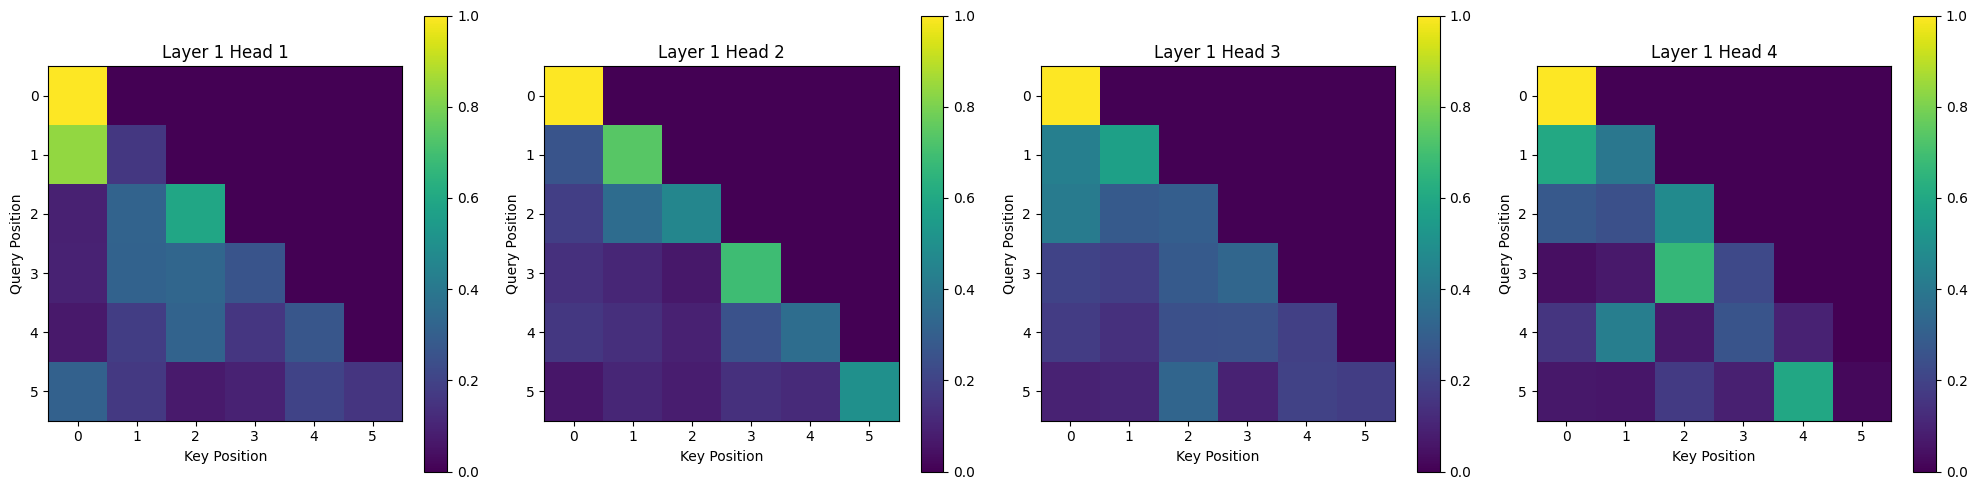

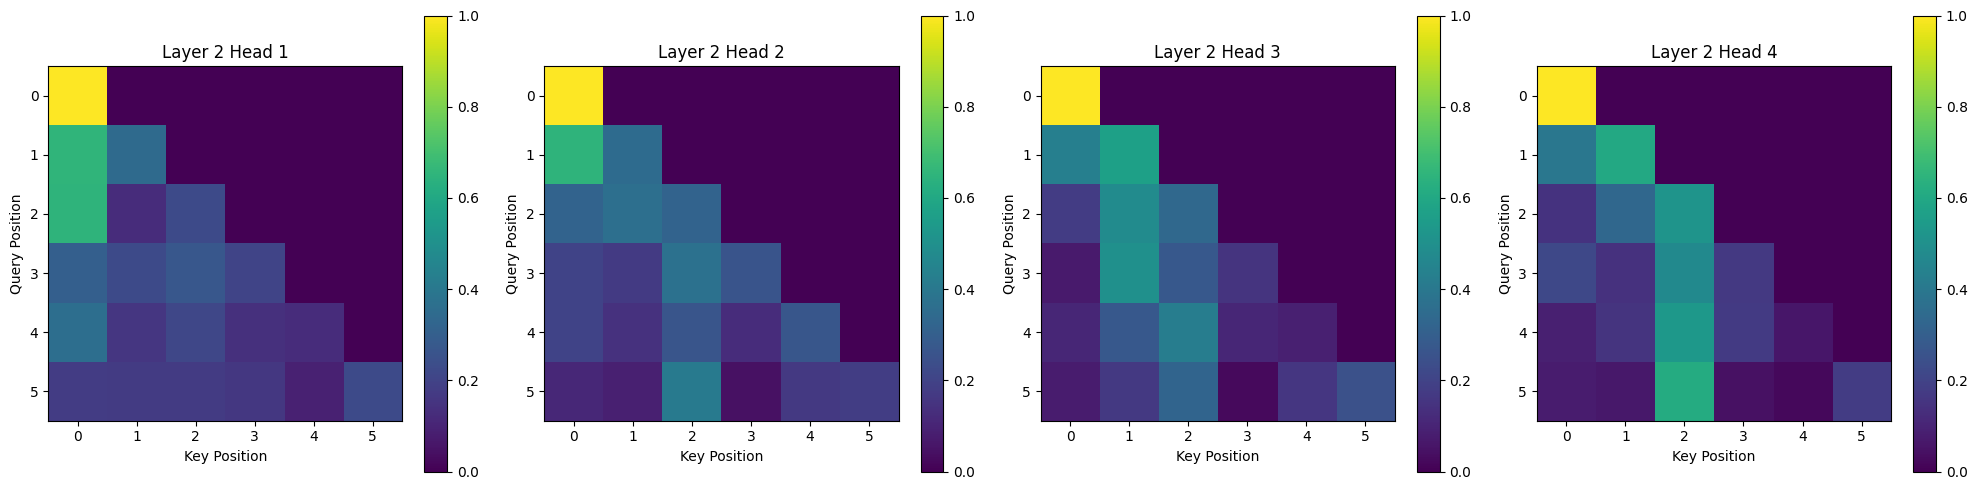

In [44]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

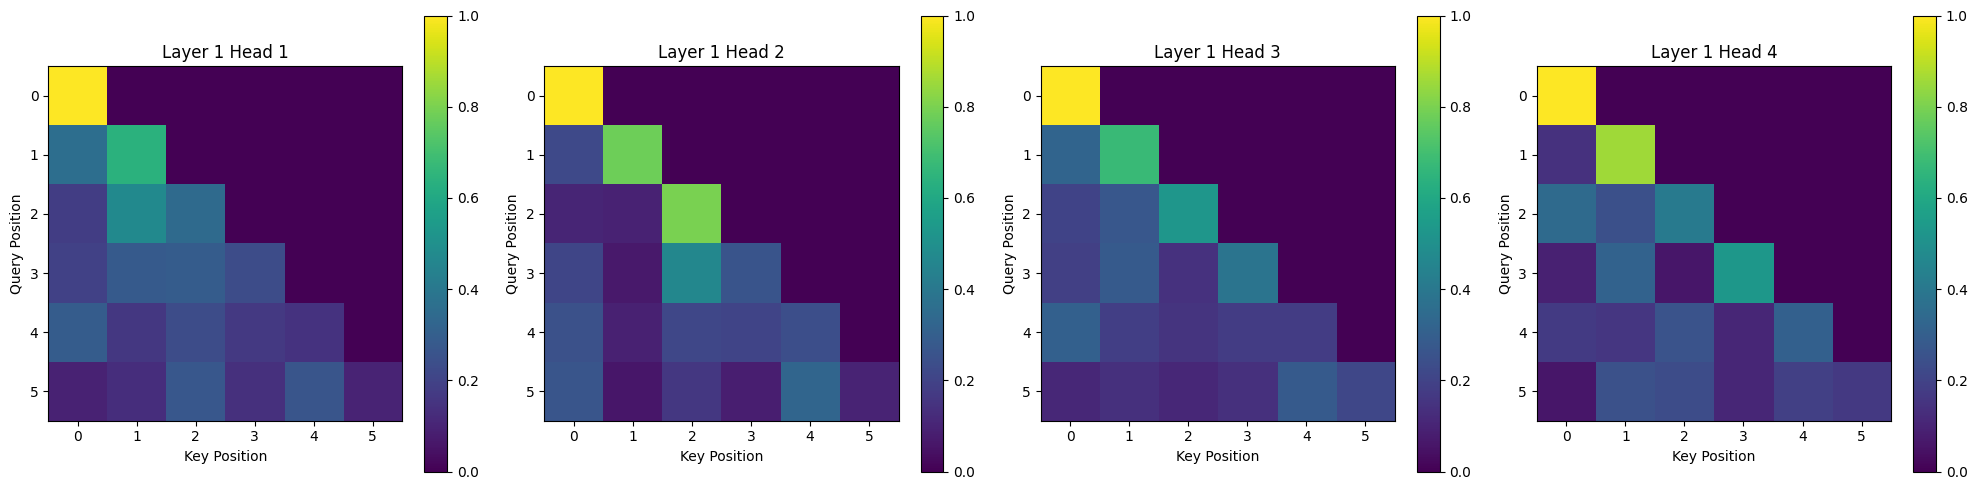

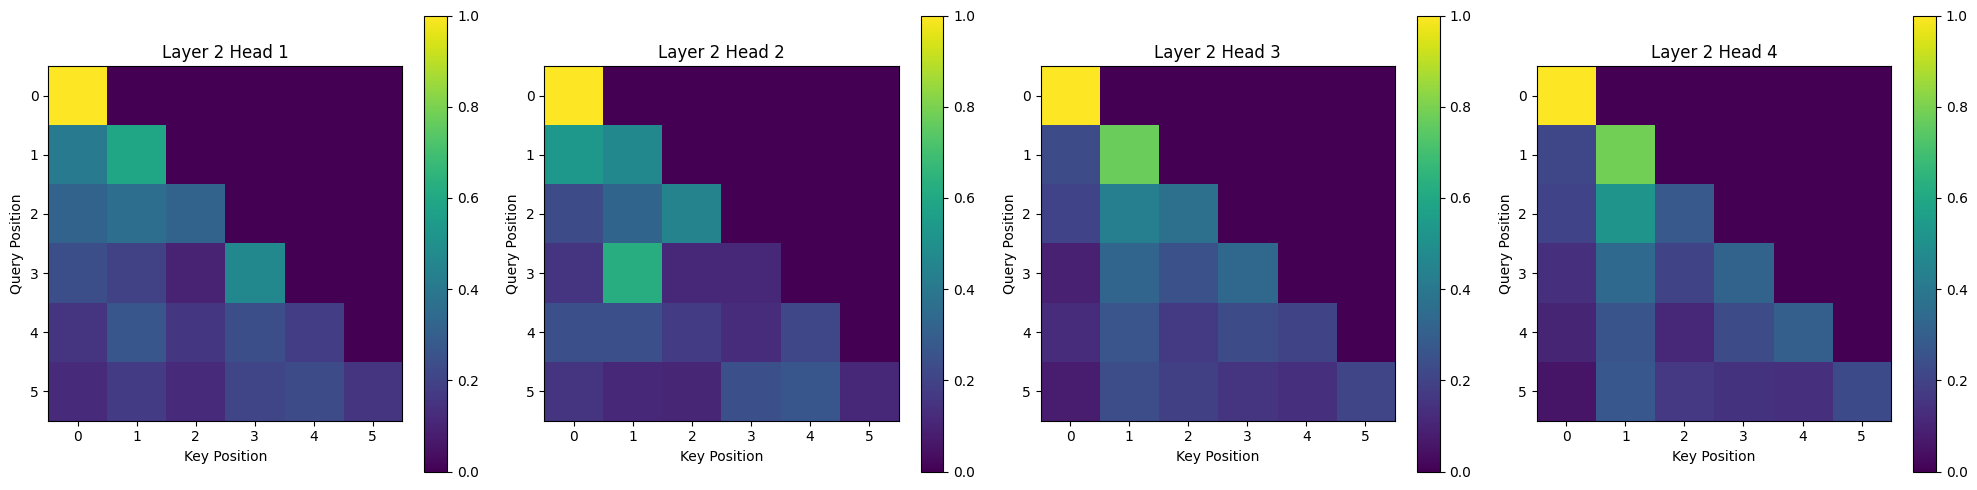

In [45]:
visualize_attention(model_moe, prompt)

# Conclusions

- La visualización evidencia que la atención ya no proviene de un único camino, sino de la combinación de múltiples expertos, lo que genera patrones más variados y menos uniformes.

- La mezcla de expertos produce cabezas con comportamientos más diferenciados, reflejando funciones internas distintas según el tipo de transformación que aporta cada experto.

- Algunas cabezas muestran atención más dispersa mientras que otras mantienen diagonales fuertes, indicando que la influencia relativa de los expertos varía según el token y la capa.

- La atención resultante es más suave y heterogénea, lo que coincide con la naturaleza del MoE: la representación es una combinación continua de varios especialistas.

- A pesar de la mayor complejidad interna, las matrices siguen mostrando un comportamiento autoregresivo correcto, garantizando estabilidad en la generación.

- Las generaciones producidas son coherentes y muestran mayor diversidad, lo cual es consistente con la intervención simultánea de múltiples expertos durante la construcción de las representaciones intermedias.

- Esta versión aporta una interpretación más rica del modelo, mostrando explícitamente cómo el MoE influye en la estructura interna de la atención sin cambiar la arquitectura base del transformer.

# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

